# [프로젝트] 멀티 에이전트 기반 보고서 작성과 품질 관리


이번 실습에서는, 기업의 재무 공시 정보와 최근 뉴스를 바탕으로 보고서를 작성하는 에이전트를 만들어 보겠습니다.   

이는 단순 검색보다는 최신성을 가진 뉴스나 공시 등의 전문 자료의 내용이 중요합니다.


In [1]:
!pip install langchain==1.0.3
!pip install langgraph dotenv arxiv langchain-tavily langchain-community langchain-google-genai pymupdf

In [2]:
!pip install xmltodict kiwipiepy sentence-transformers langchain_huggingface chromadb langchain-chroma rank-bm25 pymupdf

이번에는 공시 문서 검색을 위해 DART(https://opendart.fss.or.kr/) API 키가 필요합니다.  

해당 페이지에서 회원가입 후 API 키를 발급받습니다.   
해당 키는 .env의 DART_API_KEY 에 저장해 주세요.

In [3]:
from dotenv import load_dotenv
import os

# GOOGLE_API_KEY, TAVILY_API_KEY, DART_API_KEY 필수
# LangSmith (선택)
load_dotenv()

True

## Preliminary

### DART 공시 문서 불러오기   
공시 문서를 불러올 수 있는 DART API와 같이, 실행할 때마다 파라미터가 달라지는 경우에는 툴로 구성하는 것이 효과적일 수 있습니다.  

DART 공시 문서를 API를 통해 불러오는 함수를 구성합니다.

In [4]:
import os
import requests
from dotenv import load_dotenv
import zipfile
import io
from datetime import datetime, timedelta
import shutil
from langchain_core.tools import tool
import xmltodict

def get_dart_documents(corp_name, start_date=None, period=180):
    """
    DART API를 사용하여 특정 회사의 공시문서를 다운로드하는 함수

    Args:
        corp_name (str): 회사명 (예: '삼성전자')
        start_date (str): 시작일 (YYYYMMDD 형식, 기본값: None)
        period (int): 검색 기간(일) (기본값: 180일)

    Returns:
        str: 작업 결과 메시지

    Example:
    get_dart_documents('삼성전자', None, 120)

    """
    try:
        # .env 파일에서 API 키 로드
        load_dotenv('.env')
        api_key = os.getenv('DART_API_KEY')

        # 고유번호 찾기
        corp_code = get_corp_code(api_key, corp_name)
        if not corp_code:
            return f"{corp_name}의 고유번호를 찾을 수 없습니다."

        # 날짜 설정
        end_date = datetime.now().strftime('%Y%m%d')
        if not start_date:
            start_date = (datetime.now() - timedelta(days=period)).strftime('%Y%m%d')

        # 공시유형 설정 (A: 정기공시)
        doc_types = ['A']

        # 공시문서 검색
        disclosures = search_disclosures(api_key, corp_code, start_date, end_date, doc_types)
        if not disclosures or 'list' not in disclosures:
            return "공시문서를 찾을 수 없습니다."

        # 저장 폴더 설정
        base_folder_name = f"documents_{corp_name}"
        folder_name = base_folder_name
        counter = 1

        # 폴더가 존재하면 번호를 붙여서 새 폴더명 생성
        while os.path.exists(folder_name):
            folder_name = f"{base_folder_name}_{counter}"
            counter += 1

        os.makedirs(folder_name, exist_ok=True)

        # 검색된 공시문서 중 재무 관련 문서만 다운로드
        download_count = 0

        for doc in disclosures['list']:
            rcept_no = doc['rcept_no']
            report_nm = doc['report_nm']

            # 재무 관련 보고서만 다운로드
            if is_financial_report(report_nm):
                # 임시 ZIP 파일 경로
                temp_zip_path = f"{folder_name}/temp_{rcept_no}.zip"

                # 문서 다운로드
                success = download_document(api_key, rcept_no, temp_zip_path)

                if success:
                    # ZIP 파일 압축 풀기 - 별도 폴더 생성 없이 바로 지정된 폴더에 압축 해제
                    with zipfile.ZipFile(temp_zip_path, 'r') as zip_ref:
                        zip_ref.extractall(folder_name)

                    # 임시 ZIP 파일 삭제
                    os.remove(temp_zip_path)

                    download_count += 1

        if download_count > 0:
            return (True, folder_name)
        else:
            return (False, "재무 관련 공시문서가 없습니다.")

    except Exception as e:
        return f"에러가 발생했습니다. {e}"

def get_corp_code(api_key, corp_name):
    """
    회사명으로 고유번호를 찾는 함수

    Args:
        api_key (str): DART API 키
        corp_name (str): 회사명
    Returns:
        str: 고유번호
    """
    url = 'https://opendart.fss.or.kr/api/corpCode.xml'
    params = {
        'crtfc_key': api_key
    }

    try:
        response = requests.get(url, params=params)
        if response.status_code == 200:
            f = io.BytesIO(response.content)
            zfile = zipfile.ZipFile(f)
            xml = zfile.read("CORPCODE.xml").decode("utf-8")
            dict_data = xmltodict.parse(xml)
            for corp in dict_data['result']['list']:
                if corp['corp_name'] == corp_name:
                    return corp['corp_code']
            return None
    except Exception as e:
        return None

def search_disclosures(api_key, corp_code, start_date=None, end_date=None, doc_types=None):
    """
    공시문서를 검색하는 함수

    Args:
        api_key (str): DART API 키
        corp_code (str): 고유번호
        start_date (str): 시작일 (YYYYMMDD)
        end_date (str): 종료일 (YYYYMMDD)
        doc_types (list): 검색할 공시유형 목록 (기본값: 정기공시)
    Returns:
        list: 검색된 공시문서 리스트
    """
    if not doc_types:
        doc_types = ['A']  # 기본값: 정기공시(A)

    url = 'https://opendart.fss.or.kr/api/list.json'
    params = {
        'crtfc_key': api_key,
        'corp_code': corp_code,
        'bgn_de': start_date,
        'end_de': end_date,
        'page_count': '100'  # 최대 100개까지 검색
    }

    # 공시유형 필터링
    if len(doc_types) == 1:
        params['pblntf_ty'] = doc_types[0]

    try:
        response = requests.get(url, params=params)
        if response.status_code == 200:
            return response.json()
        else:
            return None
    except Exception as e:
        return None

def is_financial_report(report_nm):
    """
    보고서가 재무 관련 보고서인지 확인하는 함수

    Args:
        report_nm (str): 보고서명
    Returns:
        bool: 재무 관련 보고서이면 True, 아니면 False
    """
    financial_keywords = [
        '사업보고서', '분기보고서', '반기보고서', '감사보고서',
        '영업(잠정)실적', '매출액', '영업이익', '당기순이익',
        '재무제표', '정기주주총회', '실적발표', '결산실적',
        '전망', '배당', '유상증자', '타법인주식', '투자판단'
    ]

    return any(keyword in report_nm for keyword in financial_keywords)

def download_document(api_key, rcept_no, save_path):
    """
    DART API를 사용하여 공시문서를 다운로드하는 함수

    Args:
        api_key (str): DART API 키
        rcept_no (str): 접수번호
        save_path (str): 저장할 파일 경로
    Returns:
        bool: 다운로드 성공 여부
    """
    url = 'https://opendart.fss.or.kr/api/document.xml'
    params = {
        'crtfc_key': api_key,
        'rcept_no': rcept_no
    }

    try:
        response = requests.get(url, params=params)
        if response.status_code == 200:
            with open(save_path, 'wb') as f:
                f.write(response.content)
            return True
        else:
            return False
    except Exception as e:
        return False


In [5]:
corp_name = '삼성전자'

result, dart_dir = get_dart_documents(corp_name, 20240501, 120)
result, dart_dir

(True, 'documents_삼성전자_2')

공시 문서의 형식은 xml이므로, 적절한 방법을 통해 불러와야 합니다.
본 실습에서는 하드코딩된 방법을 사용하지만, 추후 더 좋은 툴이 있다면 해당 툴로 변경하는 것이 높은 성능에 도움이 됩니다.

In [6]:
from glob import glob
xml_list = glob(f'./{dart_dir}/*.xml')

In [7]:
# Gemini 2.5 Pro에게 XML 일부를 입력하고 작성함
import re
import os
from bs4 import BeautifulSoup

def parse_xml(file_path: str) -> str:
    """
    DART 공시 XML 파일을 파싱하여 RAG에 적합한 형식의 텍스트로 변환합니다.

    Args:
        file_path: 파싱할 XML 파일의 경로.

    Returns:
        추출 및 정제된 텍스트 전체를 담은 단일 문자열.
        파일 처리 중 오류 발생 시 빈 문자열을 반환할 수 있습니다.
    """
    extracted_data = []
    current_section_title = "문서 서두" # 기본 섹션 제목

    # --- 1. 파일 존재 확인 및 읽기 ---
    if not os.path.exists(file_path):
        print(f"오류: 파일을 찾을 수 없습니다 - {file_path}")
        return ""
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            xml_content = f.read()
    except Exception as e:
        print(f"오류: 파일 읽기 실패 {file_path} - {e}")
        return ""

    # --- 2. XML 파싱 ---
    try:
        # lxml 파서가 설치되어 있다면 속도와 안정성 면에서 더 좋습니다.
        try:
            soup = BeautifulSoup(xml_content, 'lxml-xml')
        except ImportError:
            print("lxml 파서가 없어 내장 'xml' 파서를 사용합니다. 'pip install lxml'로 설치할 수 있습니다.")
            soup = BeautifulSoup(xml_content, 'xml')
    except Exception as e:
        print(f"오류: XML 파싱 실패 {file_path} - {e}")
        return ""

    # --- 3. BODY 태그 찾기 (없으면 전체 문서 처리 시도) ---
    body = soup.find('BODY')
    if not body:
        print(f"경고: {file_path} 파일에서 <BODY> 태그를 찾을 수 없습니다. 문서 전체를 처리합니다.")
        process_root = soup # BODY 없으면 문서 전체를 기준으로 처리
    else:
        process_root = body # BODY 태그 내부를 기준으로 처리

    # --- 4. 내용 순회 및 추출 ---
    try:
        # process_root의 모든 자손 태그를 순회
        for element in process_root.descendants:
            # 유효한 태그 이름이 없는 요소는 건너뛰기 (예: NavigableString)
            if not hasattr(element, 'name') or element.name is None:
                continue

            # --- 섹션 제목 처리 ---
            # 실제 DART 문서의 제목 태그 확인 필요 (예: 'TITLE', 'H2', 'H3' 등)
            # 목차 항목 제외 (ATOC='N' 또는 다른 구분자 확인)
            if element.name == 'TITLE' and element.get('ATOC') != 'N':
                title_text = element.get_text(strip=True)
                # 제목이 비어있지 않고, 이전 제목과 다를 경우 업데이트
                if title_text and title_text != current_section_title:
                     current_section_title = title_text
                     # 마크다운 헤더 형식으로 추가
                     extracted_data.append(f"\n## {current_section_title}\n")

            # --- 문단(P) 처리 ---
            elif element.name == 'P':
                text = element.get_text(strip=True)
                # 문단 내용이 있고, 단순히 숫자만 있는 경우가 아닐 때 추가 (서식용 숫자 제외)
                if text and not text.isdigit():
                    extracted_data.append(text)

            # --- 테이블(TABLE) 처리 ---
            elif element.name == 'TABLE':
                caption_tag = element.find('CAPTION') # 테이블 설명(캡션) 찾기
                caption = caption_tag.get_text(strip=True) if caption_tag else "표" # 캡션 없으면 기본값 '표'

                rows_data = []
                # 테이블의 행(TR 또는 ROW) 찾기 - recursive=False 로 바로 아래 자식만 찾기 시도 가능
                for row in element.find_all(['TR', 'ROW']): # 실제 행 태그 확인 필요
                    # 행 내부의 셀(TD, TH, CELL, TU) 찾기
                    cells = [cell.get_text(strip=True) for cell in row.find_all(['TD', 'TH', 'CELL', 'TU'])] # 실제 셀 태그 확인 필요
                    # 빈 셀 제거
                    cells = [cell for cell in cells if cell]
                    # 셀 내용이 있을 경우에만 행 추가
                    if cells:
                        rows_data.append(" | ".join(cells)) # 파이프(|)로 셀 내용 구분

                # 추출된 행 데이터가 있을 경우에만 테이블 텍스트 생성 및 추가
                if rows_data:
                    table_text = f"\n[{caption}]\n" + "\n".join(rows_data) + "\n"
                    extracted_data.append(table_text)

            # --- 기타 필요한 태그 처리 ---
            # 예: 리스트(UL, OL, LI), 특정 강조(SPAN with attribute) 등 필요시 추가

    except Exception as e:
        print(f"오류: 내용 처리 중 예외 발생 {file_path} - {e}")
        # 부분적으로 추출된 데이터라도 반환할지 결정 (현재는 계속 진행)

    # --- 5. 추출된 텍스트 결합 및 최종 정리 ---
    final_text = "\n".join(extracted_data)

    # 연속된 빈 줄(3개 이상)을 2개로 줄이기
    final_text = re.sub(r'\n{3,}', '\n\n', final_text).strip()

    # 선택적: 테이블 구분선처럼 보이는 라인 제거 (필요시 주석 해제 및 패턴 조정)
    # final_text = "\n".join([line for line in final_text.split('\n') if not re.match(r'^[\s|\-_=]+$', line)])

    return final_text


In [8]:
from langchain_community.document_loaders import UnstructuredXMLLoader
from langchain_core.documents import Document
docs = []
for xml in xml_list:
   doc = Document(page_content = parse_xml(xml), metadata={'type':'DART', 'source':xml})
   docs.append(doc)
   print(len(doc.page_content))

91141
104378
29033
26568
44095
26794
39526
39526


In [9]:
print(docs[0].page_content[20000:21000])

소들에 따라 달라질 수 있습니다. 퇴직연금의 순원가(이익)를 결정하는 데 사용되는 가정은 할인율을 포함하고 있으며, 이러한 가정의 변동은 순확정급여부채(자산)의 장부금액에 영향을 줄 것입니다. 회사는 매년 말 우량회사채 이자율을 고려하여 적절한 할인율을 결정하고 있으며, 이러한 할인율은 순확정급여부채(자산)의 정산시 발생할 것으로 예상되는 미래의 추정 현금 유출액의 현재가치를 결정할 때 사용됩니다. 순확정급여부채(자산)와 관련된 다른 주요한 가정들 중 일부는 현재의 시장 상황에 근거하고 있습니다.
사. 영업권 및 내용연수가 비한정인 무형자산의 손상
회사는 매년 영업권 및 내용연수가 비한정인 무형자산의 손상 여부를 검토하고 있습니다. 현금창출단위 또는 자산의 회수가능금액은 사용가치의 계산에 기초하여 결정하고 있습니다. 이러한 계산은 추정에 근거하여 이루어집니다.
아. 법인세
회사의 과세소득에 대한 법인세는 다양한 국가의 세법 및 과세당국의 결정을 적용하여 산정되므로 최종 세효과를 산정하는 데에는 불확실성이 존재합니다. 회사는 보고기간종료일 현재까지의 영업활동의 결과로 미래에 부담할 것으로 예상되는 법인세효과를 최선의 추정과정을 거쳐 당기법인세 및 이연법인세로 인식하였습니다. 하지만 실제 미래 최종 법인세부담은 인식한 관련 자산ㆍ부채와 일치하지 않을 수 있으며, 이러한 차이는 최종 세효과가 확정된 시점의 당기법인세 및 이연법인세 자산ㆍ부채에 영향을 줄 수 있습니다.  회사는 특정 기간 동안 과세소득의 일정 금액을 투자, 임금증가 등에 사용하지 않았을 때 세법에서 정하는 방법에 따라 산정된 법인세를 추가로 부담합니다.  따라서 해당 기간의 당기법인세와 이연법인세를 측정할 때 이에 따른 세효과를 반영하여야 하고, 이로 인해 회사가 부담할 법인세는 각 연도의 투자, 임금증가 등의 수준에 따라 달라지므로 최종 세효과를 산정하는 데에는 불확실성이 존재합니다.회사는 법인세 처리의 불확실성 여부를 검토하고 있으며, 과세당국이 불확실한 법인세 처리를 수용할 가능성이 높지 않다고

각각의 토큰 수도 확인해 보겠습니다.

In [10]:
import google.generativeai as genai

model = genai.GenerativeModel("models/gemini-2.0-flash")

for doc in docs:
    print(f"FILE: {doc.metadata['source']} ({len(doc.page_content)}) \n {model.count_tokens(doc.page_content)}")

FILE: ./documents_삼성전자_2/20250311001085_00760.xml (91141) 
 total_tokens: 58725
prompt_tokens_details {
  modality: TEXT
  token_count: 58725
}

FILE: ./documents_삼성전자_2/20250311001085_00761.xml (104378) 
 total_tokens: 70176
prompt_tokens_details {
  modality: TEXT
  token_count: 70176
}

FILE: ./documents_삼성전자_2/20240516001421.xml (29033) 
 total_tokens: 16440
prompt_tokens_details {
  modality: TEXT
  token_count: 16440
}

FILE: ./documents_삼성전자_2/20250515001922.xml (26568) 
 total_tokens: 15673
prompt_tokens_details {
  modality: TEXT
  token_count: 15673
}

FILE: ./documents_삼성전자_2/20250311001085.xml (44095) 
 total_tokens: 27616
prompt_tokens_details {
  modality: TEXT
  token_count: 27616
}

FILE: ./documents_삼성전자_2/20241114002642.xml (26794) 
 total_tokens: 15759
prompt_tokens_details {
  modality: TEXT
  token_count: 15759
}

FILE: ./documents_삼성전자_2/20250814003156.xml (39526) 
 total_tokens: 23733
prompt_tokens_details {
  modality: TEXT
  token_count: 23733
}

FILE: ./docume

해당 문서를 전부 Context로 넣는 것보다는, 청킹을 통해 필요한 부분만 검색할 수 있도록 구성해 봅시다.   
랭체인에서는 제미나이 토큰 수 기반의 청킹을 지원하지는 않기 때문에, 글자 수 기반의 청킹을 수행합니다.

### 청크 사이즈와 Top K는 어떻게 잡으면 좋을까요?

우리가 사용하는 Gemini 계열의 모델은 1M Context Size기 때문에 많은 내용을 처리할 수 있는데요.   
그러나, Context 길이가 상대적으로 짧은 모델들(128k, 200k 또는 그 이하)의 경우는 청크 사이즈를 작게 만드는 것이 더 효과적일 수 있습니다.   



또한, Context에 포함하기 위한 Top K를 설정하는 것도 중요합니다.   
긴 Context 모델은 Top K를 늘려 풍부한 정보를 파악할 수 있습니다.

In [11]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Context가 작은 모델이라면, 청크를 줄이는 것이 좋습니다.
# chunk_size = 3000
# chunk_overlap = 600
# top_k = 5

text_splitter = RecursiveCharacterTextSplitter(chunk_size=6000, chunk_overlap=600)

chunks = text_splitter.split_documents(docs)
print(len(chunks))

78


각각의 청크를 벡터 DB에 저장합니다.

In [12]:
from huggingface_hub import login

# 허깅페이스 토큰 로그인: 아래 코드에서 보통 필요하지 않으나, 필요한 경우 READ TOKEN
# login(token=os.environ['HF_TOKEN'])

In [13]:
# 임베딩 모델 준비 (에러 발생시 위 셀에서 토큰으로 로그인)


from sentence_transformers import SentenceTransformer
from langchain_huggingface import HuggingFaceEmbeddings

model_name = 'Qwen/Qwen3-Embedding-0.6B'
emb_model = SentenceTransformer(model_name, device='cpu')

emb_model.save('./embedding')
del emb_model

import gc
gc.collect()

embeddings = HuggingFaceEmbeddings(model_name= './embedding',
                                   model_kwargs={'device':'cuda'})
# GPU가 있는 경우, CUDA(GPU) 설정

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [14]:
from langchain_chroma import Chroma
from tqdm import tqdm

Chroma().delete_collection()

# DB 구성하기
vector_store = Chroma(embedding_function=embeddings,
             # persist_directory="./chroma_web",
            # 파일 시스템에 저장 (생략시 메모리에 저장)

            collection_name='Web', # 식별 이름

            collection_metadata={'hnsw:space':'l2'},
            # l2 메트릭 설정(기본값, cosine, mmr 로 변경 가능)
            )

# 3개씩 추가 (GPU에 따라 늘려도 됨)
for i in tqdm(range(0, len(chunks), 3)):
    vector_store.add_documents(chunks[i:min(i+3, len(chunks))])


retriever = vector_store.as_retriever(search_kwargs={"k": 5})
# Small Model은 작게

100%|██████████| 26/26 [03:49<00:00,  8.83s/it]


### Hybrid RAG

임베딩 기반 검색도 필요하지만, 전문적인 도메인 문서의 경우에는 키워드 기반의 검색도 필요합니다.   
랭체인의 `BM25Retriever`와 `EnsembleRetriever` 를 이용하여 두 검색을 결합해 보겠습니다.   
한국어 데이터의 경우, 랭체인의 기본 인덱싱에서 처리하지 못하기 때문에    
별도의 형태소 분석기를 추가합니다.

In [15]:
from langchain_classic.retrievers import BM25Retriever, EnsembleRetriever

from kiwipiepy import Kiwi
# kiwi 형태소 분석기
kiwi = Kiwi()
def kiwi_tokenize(text):
    return [token.form for token in kiwi.tokenize(text)]

bm25_retriever = BM25Retriever.from_documents(chunks, preprocess_func = kiwi_tokenize)
bm25_retriever.k = 5

ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, retriever], weights=[0.5, 0.5]
)


LLM을 설정합니다. 이번에는 하나의 모델만 사용하겠습니다.

In [16]:
import os
from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain.chat_models import init_chat_model
from rich import print as rprint

# Gemini API는 분당 10개 요청으로 제한
# 즉, 초당 약 0.167개 요청 (10/60)
rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.167,  # 분당 10개 요청
    check_every_n_seconds=0.1,  # 100ms마다 체크
    max_bucket_size=10,  # 최대 버스트 크기
)

quick_rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.333,  # 분당 20개 요청
    check_every_n_seconds=0.1,  # 100ms마다 체크
    max_bucket_size=20,  # 최대 버스트 크기
)

llm = init_chat_model(
    model_provider="google_genai",
    model="gemini-2.0-flash",

    rate_limiter=rate_limiter,
    temperature=0.8,
    max_tokens = 8192
)


quick_llm = init_chat_model(
    model_provider="google_genai",
    model="gemini-2.0-flash-lite",

    rate_limiter=quick_rate_limiter,
    temperature=0.8,
    max_tokens = 8192
)

In [17]:
# 결과 비교 (Lexical Win)

question = '''연결회사의 '기타포괄손익-공정가치 금융자산'과 '당기손익-공정가치 금융자산'으로 분류된 상장주식의 주가가 1% 변동할 경우, 2024년 3분기말 기준으로 기타포괄손익과 당기손익에 미치는 영향(세전)은 각각 얼마인가?'''
# 정답: 주가 1% 변동 시 기타포괄손익(법인세효과 반영 전)에 미치는 영향은 58,830백만원이고, 당기손익(법인세효과 반영 전)에 미치는 영향은 2,333백만원 입니다.

for rt in [retriever, bm25_retriever, ensemble_retriever]:
    print(type(rt))
    result = rt.invoke(question)
    context = '\n\n'.join([chunk.page_content for chunk in result])

    print(llm.invoke(f'''
다음 검색 결과를 보고 질문에 답하세요.

{context}

{question}''').content)


    print('-----')

<class 'langchain_core.vectorstores.base.VectorStoreRetriever'>
제공된 정보에 따르면,

*   **기타포괄손익** (법인세 효과 반영 전): 76,865백만원
*   **당기손익** (법인세 효과 반영 전): 862백만원

따라서 상장주식의 주가가 1% 변동할 경우, 2024년 3분기말 기준으로 기타포괄손익은 76,865백만원, 당기손익은 862백만원의 영향을 받습니다.
-----
<class 'langchain_community.retrievers.bm25.BM25Retriever'>
제공된 검색 결과에서 2024년 3분기말에 대한 정보는 찾을 수 없습니다.

다음은 2024년 1분기말과 2024년말에 대한 정보입니다.

**2024년 1분기말:**

*   **기타포괄손익:** 주가가 1% 변동 시 58,830백만원 영향
*   **당기손익:** 주가가 1% 변동 시 2,333백만원 영향

**2024년말:**

*   **기타포괄손익:** 주가가 1% 변동 시 76,865백만원 영향
*   **당기손익:** 주가가 1% 변동 시 862백만원 영향
-----
<class 'langchain_classic.retrievers.ensemble.EnsembleRetriever'>
*   **기타포괄손익:** 58,830백만원
*   **당기손익:** 2,333백만원
-----


In [18]:
# 결과 비교 (Semantic Win)

question = '''매출액 비중이 가장 큰 데가 어디예요? 얼마인가요?'''
# 정답: DX 부문, 매출액은 1조 3,435억 7,500만 원

for rt in [retriever, bm25_retriever, ensemble_retriever]:
    print(type(rt))
    result = rt.invoke(question)
    context = '\n\n'.join([chunk.page_content for chunk in result])

    print(llm.invoke(f'''
다음 검색 결과를 보고 질문에 답하세요.

{context}

{question}''').content)


    print('-----')

<class 'langchain_core.vectorstores.base.VectorStoreRetriever'>
2024년 매출액 비중이 가장 큰 지역은 **미주**이며, 매출액은 **118조 8,285억원**입니다.
-----
<class 'langchain_community.retrievers.bm25.BM25Retriever'>
제공된 검색 결과 내에서는 매출액 비중이나 매출액에 대한 직접적인 정보를 찾을 수 없습니다. 하지만 DX 부문, 특히 TV와 모바일 산업이 삼성전자의 주요 사업 부문임을 확인할 수 있습니다. 더 자세한 매출 관련 정보는 재무제표를 참고해야 합니다.
-----
<class 'langchain_classic.retrievers.ensemble.EnsembleRetriever'>
2024년 매출액 비중이 가장 큰 지역은 미주로, 118조 8,285억 원입니다.
-----


검색 API를 구성합니다.   
Tavily Search도 툴로 만들어 보겠습니다.

In [19]:
# Tavily Search

from langchain_tavily import TavilySearch
from typing_extensions import Optional
@tool
def web_search(
    query: str,
    time_range: Optional[str] = None,
    topic: str = "general",
    max_results: int = 5
) -> str:
    """웹 검색을 수행하는 도구입니다.

    Args:
        query: 검색할 쿼리
        time_range: 검색 시간 범위 (None, 'day', 'week', 'month', 'year')
        topic: 검색 주제 ('general', 'finance', 'news')
        max_results: 최대 검색 결과 수 (기본값 5)

    Returns:
        검색 결과 문자열
    """
    tavily_search = TavilySearch(
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
        time_range=time_range
    )

    result = tavily_search.invoke(query)['results']
    return result

llm_with_tools = llm.bind_tools([web_search])
result = llm_with_tools.invoke("삼성전자의 최근 실적에 대한 뉴스 찾아줄래?")
rprint(result)


AIMessage(
    content='',
    additional_kwargs={
        'function_call': {
            'name': 'web_search',
            'arguments': '{"time_range": "month", "query": "\\uc0bc\\uc131\\uc804\\uc790 \\ucd5c\\uadfc 
\\uc2e4\\uc801", "topic": "finance"}'
        }
    },
    response_metadata={
        'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
        'finish_reason': 'STOP',
        'model_name': 'gemini-2.0-flash',
        'safety_ratings': [],
        'grounding_metadata': {},
        'model_provider': 'google_genai'
    },
    id='lc_run--046a6d93-aaa9-43b8-bc3b-e3184b8651cd-0',
    tool_calls=[
        {
            'name': 'web_search',
            'args': {'time_range': 'month', 'query': '삼성전자 최근 실적', 'topic': 'finance'},
            'id': 'b865cc63-12fe-43e1-bcde-c4af31fa13e4',
            'type': 'tool_call'
        }
    ],
    usage_metadata={
        'input_tokens': 130,
        'output_tokens': 18,
        'total_tokens': 148,
        'input_token_details': {'cache_read': 0}
    }
)

위 기능을 활용하여, 전체 플로우를 구성해 보겠습니다.

전체 과정은 다음과 같이 이루어집니다.

1) 사용자가 기업에 대한 질문을 입력하면, LLM이 이 질문에 답하기 위한 보고서의 섹션을 구성합니다. (최종 의견을 포함해야 합니다.)

2) 질문에 답변하기 위한 DART 공시 검색과 Tavily 검색을 통해 데이터를 모으고, 이를 Vector DB에 저장합니다.   

3) 전체 데이터에 대해, LLM이 질문에 대한 RAG를 수행하여 섹션별 청크를 검색하고, 내용을 채웁니다.  

4) 완성된 보고서를 정성적/정량적으로 평가합니다.

5) 평가 결과에 따라, 휴먼 피드백을 요청하거나 DB에 저장합니다.


In [20]:
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import PydanticOutputParser, StrOutputParser
from langgraph.types import Command, interrupt
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from pydantic import BaseModel, Field
from typing_extensions import Annotated, Literal
import operator
from langgraph.types import Send
from langchain_core.runnables.config import RunnableConfig
from typing_extensions  import TypedDict, Optional
from langchain_core.messages import SystemMessage, HumanMessage


In [21]:
from langchain_core.runnables.config import RunnableConfig
from typing_extensions  import TypedDict, Optional, Callable, Any

class Configuration(TypedDict):
    num_search_queries: int
    BM25_ratio_for_DART : float
    BM25_ratio_for_Web : float


# Default
default = Configuration(
    num_search_queries=3, # 섹션별 질문 쿼리 수
    BM25_ratio_for_DART = 0.7,
    BM25_ratio_for_Web = 0.5
)

In [22]:
class Section(BaseModel):
    name: str = Field(description="섹션의 이름")
    description: str = Field(description="해당 섹션에서 다룰 주요 주제에 대한 간략한 개요")
    content: str = Field(description="섹션의 내용 (처음에는 비워 둡니다)")

    @property
    def as_str(self) -> str:
        """섹션의 정보를 포맷팅된 문자열로 변환합니다."""
        return f"### {self.name}\n{self.description}\n\n내용:\n{self.content}"


class ReportPlan(BaseModel):
    sections: list[Section] = Field(description="A list of sections for the report.")
    @property
    def as_str(self) -> str:
        """섹션들을 포맷팅된 문자열로 변환합니다."""
        sections_str = []
        for section in self.sections:
            sections_str.append(f"### {section.name}\n{section.description}")
        return "\n\n".join(sections_str)

In [23]:
class QualityScore(BaseModel):
    """
    생성된 보고서의 품질을 다양한 기준에 따라 평가합니다.
    각 항목은 1점(매우 미흡)부터 5점(매우 우수)까지의 점수로 평가됩니다.
    """
    factual_accuracy: int = Field(
        description="""사실 기반 정확성 (Factual Accuracy / Groundedness):
근거 없는 주장이나 환각(Hallucination)은 없는가? (1-5점)""",
    )
    relevance: int = Field(
        description="""관련성 (Relevance): 내용이 사용자의 초기 질문
및 각 섹션의 본래 목적에 부합하는가?
불필요하거나 주제에서 벗어난 내용은 없는가? (1-5점)""",
    )
    completeness: int = Field(
        description="""완결성 (Completeness):
계획된 모든 섹션(Outline 기준)이 보고서에 포함되어 있으며,
각 섹션의 내용이 충분히 다루어졌는가? (1-5점)""",
    )
    coherence_flow: int = Field(
        description="""일관성 및 흐름 (Coherence & Flow):
섹션 간의 연결이 자연스럽고 논리적인가?
전체적인 글의 흐름이 매끄러운가? (1-5점)""",
    )
    clarity_conciseness: int = Field(
        description="""명확성 및 간결성 (Clarity & Conciseness):
전문 용어 사용이 적절하며, 모호하지 않고 이해하기 쉽게 작성되었는가?
불필요하게 길거나 복잡한 문장은 없는가? (1-5점)""",
    )
    objectivity: int = Field(
        description="""객관성 (Objectivity):
보고서의 어조가 중립적이고 사실에 기반하는가?
편향된 시각이나 과도한 추측은 없는가? (1-5점)""",
    )
    overall_score: int = Field(
        description="""종합 점수 (Overall):
위 기준들을 종합적으로 고려한 전체 보고서 품질 점수 (1-5점)""",
    )

In [24]:
class State(TypedDict):
    current_date:str # 오늘의 날짜
    question: str # 사용자의 질문
    queries : str # 검색 쿼리 목록
    web_search_q : Annotated[list, operator.add] # 검색 요청 목록
    dart_search_q : Annotated[list, operator.add]
    plan: ReportPlan # 답변 보고서 개요
    result: str # 최종 결과물 (하나로 합쳐진)
    finished_drafts: Annotated[list[str], operator.add]

    DART_DB_PATH: str # Dart DB Path
    WEB_DB_PATH: str # Web DB Path

    dart_docs: list
    web_docs: list


    documents: Annotated[list[str], operator.add]
    quality_score: QualityScore

class SearchState(TypedDict):

    current_date:str # 오늘의 날짜
    query : str
    documents: Annotated[list[str], operator.add]

class WriterState(TypedDict):
    question : str
    RAG_queries: list[str] # RAG에 사용할 쿼리 목록
    finished_drafts: Annotated[list[str], operator.add] # 섹션별 드래프트 (합침)
    result: str # 최종 결과물 (하나로 합쳐진)
    section :Section
    DART_DB_PATH: str # Dart DB Path
    WEB_DB_PATH: str # Web DB Path
    dart_docs: list
    web_docs: list




작업을 수행하기 전, 벡터 DB를 구성합니다.

In [25]:
import uuid

def get_current_date() -> str:
    "현재 날짜를 %y-%m-%d 형식으로 반환합니다."
    from datetime import datetime
    return datetime.now().strftime("%Y-%m-%d")

# 경로를 포함하여 추후 데이터 추가에 활용
def initiate_db(state: State, config: RunnableConfig):

    DART_DB_PATH = "./DART_"+str(uuid.uuid4())[:5]
    WEB_DB_PATH = "./WEB_"+str(uuid.uuid4())[:5]
    current_date = str(get_current_date())
    DART_vectorstore =  Chroma(persist_directory=DART_DB_PATH,
                                embedding_function=embeddings,
                                collection_name="DART")
    Web_vectorstore = Chroma(persist_directory=WEB_DB_PATH,
                                embedding_function=embeddings,
                                collection_name="web")
    return {'DART_DB_PATH': DART_DB_PATH, 'WEB_DB_PATH':WEB_DB_PATH,
            'current_date': current_date}


보고서 개요을 준비합니다.

In [26]:
def initiate_report(state: State, config: RunnableConfig):

    prompt = ChatPromptTemplate([
        ('system',f'''
Current Date: {state['current_date']}

당신은 주어진 질문에 대해, 사용자가 넓은 맥락에서 만족스러운
답변을 얻을 수 있도록 3~4 섹션 길이의 보고서를 작성해야 합니다.
해당 보고서의 개요를 작성해 주세요.

개요를 바탕으로, 기업의 공시 문서와 최근 뉴스 등을 검색하여
보고서를 작성할 것입니다.
이를 고려하여, 충분한 정보가 담긴 개요를 작성하세요.
'''),

('human', '''사용자의 질문(혹은 요청): {question}''')
    ])

    question = state['question']

    chain = prompt | llm.with_structured_output(ReportPlan)

    result = chain.invoke({'question':question})

    print(f'''
# 보고서 작성 개요:
{result.as_str}
''')
    return {'plan':result}

개요를 바탕으로 검색 쿼리를 생성합니다.   

In [27]:
def generate_search_query(state: State, config: RunnableConfig):
    prompt = ChatPromptTemplate([
('system', f'''
 Current Date: {state['current_date']}

주어진 질문에 답변하기 위한 보고서를 작성하는 과정에서, 당신은 한 섹션에 대한 자료 조사를 맡았습니다.
적절한 검색 쿼리를 한 줄에 하나씩 작성하세요.
특수문자 없이 쿼리만 출력하고, {config['configurable']['num_search_queries']} 개의 쿼리를 출력하세요.
쿼리들은 겹치지 않아야 하며, 포괄적인 정보를 수집할 수 있어야 합니다.
'''),
('user', '''
사전 질문:
{question}

전체 섹션 구성(참고용):

{contents}


당신이 맡은 섹션 정보:
{section}
''')])
    contents = state['plan']
    section_list = []
    queries=[]
    chain = prompt | llm | StrOutputParser() | (lambda x: x.split('\n'))

    for section in contents.sections:
        queries += chain.invoke({'question': question, 'section':section.as_str, 'contents':contents.as_str})
    queries = [query for query in queries if query !='']
    return {'queries':queries}

검색 쿼리를 이용해, 검색 결과를 DB에 저장합니다.   
Document의 리스트를 저장하는 툴을 만들고, LLM이 판단하여 실행하게 합니다.

In [28]:
@tool
def dart_search(corp_name: str,
                 start_date: int,
                   period:int = 180):
    """
    DART API를 사용하여 특정 회사의 공시문서를 다운로드하고, 청킹한 Document List를 Return합니다.
    Args:
        corp_name (str): 회사명 (예: '삼성전자')
        start_date (str): 시작일 (YYYYMMDD 형식, 기본값: None)
        period (int): 검색 기간(일) (기본값: 180일)

    Returns:
        str: 작업 결과 메시지

    Example:
    dart_search('삼성전자', None, 120)

    Note:
    회사명은 정확히 써야 합니다.
    """
    result, dart_dir = get_dart_documents(corp_name, start_date, period)
    xml_list = glob(f'./{dart_dir}/*.xml')
    docs = []
    for xml in xml_list:
        doc = Document(page_content = parse_xml(xml),
                       metadata={'type':'DART', 'source':xml})
        docs.append(doc)


    return docs

@tool
def web_search(
    query: str,
    time_range: Optional[str] = None,
    topic: str = "general",
    max_results: int = 5
) -> str:
    """웹 검색을 수행하는 도구입니다.

    Args:
        query: 검색할 쿼리
        time_range: 검색 시간 범위 (None, 'day', 'week', 'month', 'year')
        topic: 검색 주제 ('general', 'finance', 'news')
        max_results: 최대 검색 결과 수 (기본값 5)

    Returns:
        검색 결과 문자열
    """
    tavily_search = TavilySearch(
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
        time_range=time_range
    )

    def preprocess(text):
        import re
        # 탭과 개행문자를 공백으로 변환
        text = text.replace('\t', ' ').replace('\n', ' ').replace('\xa0', ' ')
        # 템플릿 오류 방지
        text = text.replace('{', '(').replace('}', ')')

        # 연속된 공백을 하나로 치환
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    result = tavily_search.invoke(query)

    result_docs=[]
    try:
        for res in result['results']:
            doc = Document(page_content=f"### {res['title']} \n URL: {res['url']} \n {res['raw_content']}" if res.get('raw_content') else f"### {res['title']} \n {res['content']}", metadata={'type':'Web', 'source':res['url']})
            result_docs.append(doc)
    except: # API 문제로 검색 실패
        result_docs=[]
        print(query)
        print('%%%%%%%%')
        print(result)
        print('%%%%%%%%')
    return result_docs


In [29]:
web_search.invoke({'query':'"삼성전자"'})

[Document(metadata={'type': 'Web', 'source': 'https://www.samsung.com/sec/'}, page_content='### Samsung 대한민국 | 모바일 | TV | 가전 | IT \n URL: https://www.samsung.com/sec/ \n [본문 바로가기](#container)\n\n**갤럭시 AI 폰** 구매 고객님께 드리는  \n **스마트태그2**를 지금 신청하세요!  \n(대상 모델 : S24 시리즈, S23 FE, Z Fold5 | Z Flip5, S23 시리즈)\n\n**갤럭시 캠퍼스 회원**이시네요! 리뉴얼 이벤트와   \n오리지널 콘텐츠, 더 풍성해진 커뮤니티까지!  \n**새로워진 갤럭시 캠퍼스**를 만나보세요\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n검색 결과**0** 개\n\n※ 최근 본 제품은 30일간 보관됩니다.\n\n\n\n\n[푸른빛의 직선이 왼쪽에서 오른쪽으로 이동하며 갤럭시 Z 폴드7의 얇은 옆면이 보인다. 오른쪽에 Galaxy Z Fold7 타이틀과 Galaxy AI 로고가 함께 보이며 갤럭시 Z 폴드7이 펼쳐진다.](javascript:;)\n\n## \n\n##\n\n최신 폰 구매의 최적 솔루션, 갤럭시 AI 구독클럽\n\n최신 폰 구매의 최적 솔루션, 갤럭시 AI 구독클럽\n\n[더 알아보기](javascript:;)\n\n**다시보기**\n\nGalaxy Unpacked Highlight\n\n\n\n**다시보기**\n\nkv:hero KV:Hero KV\\_banner:play youtube\n\n\n\n**다시보기**\n\nkv:hero KV:Hero KV\\_banner:1st CTA Title\n\n\n\n**다시보기**\n\n[Rainbow UNPK]Livestreaming:Go to the video\n\n\n\n\n\n## \n\n##\n\n[더 알아보기](javascript:void(0);)\n\n[## Galaxy S25 |

In [30]:
import json
def search(state: SearchState, config: RunnableConfig):

    system_prompt = SystemMessage(f'''
Current Date: {state['current_date']}

당신은 검색 봇입니다.
주어지는 정보를 찾기 위해 아래의 검색 중 어디를 검색해야 하는지 답변하세요.
이후, 검색 툴을 실행하세요.

----

웹 검색(Tavily): 구체적 재무 데이터가 아닌 뉴스 등의 정보 검색
dart_search: 공시 문서 검색

포괄적인 검색이 필요한 경우에는 두 툴을 모두 사용하세요.

입력에 명시적으로 들어 있지 않은 정보의 경우, 기본값을 사용하세요.
둘 중에 최소 하나의 툴을 무조건 사용해야 합니다.
''')
    search_llm = quick_llm.bind_tools([web_search, dart_search])

    messages = [system_prompt, HumanMessage(state['query'])]

    search_res = search_llm.invoke(messages)

    web_search_q =[]
    dart_search_q = []
    if search_res.tool_calls:
        for tool_call in search_res.tool_calls:
            tool_name = tool_call['name']
            tool_arg = tool_call['args']
            print(tool_name, tool_arg)

            # 검색을 해야 하지만, 실제로는 중복을 제거하기 위해 arg만 전달
            if tool_name =='web_search':
                web_search_q.append(tool_arg)
            else:
                dart_search_q.append(tool_arg)

    return {'web_search_q':web_search_q, 'dart_search_q': dart_search_q}




In [31]:
def start_survey(state:State, config: RunnableConfig):
    queries = state['queries']
    current_date = state['current_date']
    # Query 생성, 수집, Reflection, 섹션 작성 모듈을 하나의 에이전트로 구성
    return [Send("search",
            {'query':query, 'current_date':current_date}) for query in queries]

In [32]:
def combine_and_store(state:State, config: RunnableConfig):

    DART_DB_PATH = state['DART_DB_PATH']
    WEB_DB_PATH = state['WEB_DB_PATH']
    web_search_q = state['web_search_q']
    dart_search_q = state['dart_search_q']

    # 중복 큐 제거 (frozenset 이용)
    print(f'before dedup: {len(web_search_q)}, {len(dart_search_q)}')

    web_search_q = [dict(fs) for fs in {frozenset(d.items()) for d in web_search_q}]
    dart_search_q = [dict(fs) for fs in {frozenset(d.items()) for d in dart_search_q}]

    print(f'after dedup: {len(web_search_q)}, {len(dart_search_q)}')



    web_docs = web_search.batch(web_search_q)
    dart_docs = dart_search.batch(dart_search_q)

    # batch시 list of list: 평탄화
    web_docs = [doc for batch in web_docs for doc in batch]
    dart_docs = [doc for batch in dart_docs for doc in batch]


    text_splitter = RecursiveCharacterTextSplitter(chunk_size=6000, chunk_overlap=600)

    dart_chunks = text_splitter.split_documents(dart_docs)

    DART_vectorstore =  Chroma(persist_directory=DART_DB_PATH,
                                embedding_function=embeddings,
                                collection_name="DART")
    Web_vectorstore = Chroma(persist_directory=WEB_DB_PATH,
                                embedding_function=embeddings,
                                collection_name="web")


    # 3개씩 추가
    for i in tqdm(range(0, len(dart_chunks), 3)):
        DART_vectorstore.add_documents(dart_chunks[i:min(i+3, len(dart_chunks))])
    # 3개씩 추가
    for i in tqdm(range(0, len(web_docs), 3)):
        Web_vectorstore.add_documents(chunks[i:min(i+3, len(chunks))])

    print('Saved in VDBs')

    return {'web_docs':web_docs, 'dart_docs': dart_chunks}




DB가 구성되었으니, RAG를 통해 섹션별 글쓰기를 수행합니다.

In [33]:
def assign_writer(state: State, config: RunnableConfig):
    # 섹션별 수집된 config['configurable']['num_search_queries']개의 쿼리를 그대로 사용하여 각각의 Writer에 전달

    question = state['question']
    queries = state['queries']
    sections = state['plan'].sections
    web_docs = state['web_docs']
    dart_chunks = state['dart_docs']
    DART_DB_PATH = state['DART_DB_PATH']
    WEB_DB_PATH = state['WEB_DB_PATH']

    num_queries_per_section = config['configurable']['num_search_queries']


    section_query_list = [queries[i:i + num_queries_per_section] for i in range(0, len(queries), num_queries_per_section)]

    current_date = state['current_date']

    # 각 섹션별로 쿼리 그룹을 전달
    return [Send("write_section",
            {'question':question,
            'RAG_queries': query_group,
             'current_date': current_date,
             'section': section,
             'web_docs':web_docs,
             'dart_docs': dart_chunks,
             'DART_DB_PATH':DART_DB_PATH,
             'WEB_DB_PATH':WEB_DB_PATH})
            for query_group, section in zip(section_query_list, sections)]


In [34]:
def write_section(state: WriterState, config: RunnableConfig):
    section = state['section'].as_str
    question = state['question']
    DART_DB_PATH = state['DART_DB_PATH']
    WEB_DB_PATH = state['WEB_DB_PATH']
    queries = state['RAG_queries']
    current_date = state['current_date']
    dart_chunks = state['dart_docs']
    web_docs = state['web_docs']

    DART_vectorstore =  Chroma(persist_directory=DART_DB_PATH,
                                embedding_function=embeddings,
                                collection_name="DART")
    Web_vectorstore = Chroma(persist_directory=WEB_DB_PATH,
                                embedding_function=embeddings,
                                collection_name="web")
    def get_retriever(store, docs, BM25_ratio):
        '''각 벡터스토어에 대한 Ensemble Retriever 생성'''
        retriever = store.as_retriever(search_kwargs={'k':5})
        bm25_retriever = BM25Retriever.from_documents(docs,
                                                      preprocess_func = kiwi_tokenize)
        bm25_retriever.k = 5
        ensemble_retriever = EnsembleRetriever(
        retrievers=[bm25_retriever, retriever], weights=[BM25_ratio, 1-BM25_ratio]
        )

        return ensemble_retriever

    dart_retriever = get_retriever(DART_vectorstore, dart_chunks, config['configurable']['BM25_ratio_for_DART'])
    web_retriever = get_retriever(Web_vectorstore, web_docs, config['configurable']['BM25_ratio_for_Web'])

    context = []
    for query in queries:
        context+= web_retriever.invoke(query)
        context+= dart_retriever.invoke(query)

    # 중복 제거
    context = [doc for i, doc in enumerate(context) if doc not in context[:i]]

    writer_prompt =ChatPromptTemplate([
        ('system', f'''
Current Date: {current_date}

사용자의 질문과 이에 답변하기 위한 보고서의 세부 섹션명이 주어집니다.
다음의 정보를 활용하여, 보고서의 섹션을 작성하세요.
다음은 작성 가이드라인입니다.

[작성 가이드라인]
간단하고 명확한 언어를 사용하세요.
섹션명은 마크다운 ## 으로 작성하며, 세부 목차는 만들지 말고 문단으로만 분리하세요.
문장을 너무 길게 쓰지 말고, 이해하기 쉽게 작성하세요.
'이다.' 가 아닌 '입니다.', '합니다.' 등의 스타일로 작성하세요.
또한, 아래에 주어지는 정보의 내용을 최대한 활용하여 작성하세요.
'''),

('user','''
질문: {question}

세부 섹션명: {section}

검색 결과 Context:
{context}
''')
])
    chain = writer_prompt | llm | StrOutputParser()
    draft = chain.invoke({'question':question, 'section':section,
                          'context':['\n---\n'.join([doc.page_content for doc in context])] })
    return {'finished_drafts':[draft]}

In [35]:
def synthesizer(state:State, config: RunnableConfig):
    return {'result':'\n'.join(state['finished_drafts'])}

마지막으로, 평가 함수를 구성합니다.

In [36]:
def evaluate(state: State, config: RunnableConfig):
    prompt = ChatPromptTemplate([
("system", """당신은 보고서 품질 평가 전문가입니다. 주어진 보고서 텍스트를 주어진 기준에 따라 평가하고, 각 기준별 점수(1-5점)와 종합 점수를 반환하세요."""),
("user","""
사용자 질문: {question}

보고서 구획:
{sections}

평가 대상 보고서:
{result}
""")])
    chain = prompt | llm.with_structured_output(QualityScore)

    result = chain.invoke({'question':state['question'],
                  'sections':state['plan'].as_str,
                  'result':state['result']})

    return {'quality_score':result}

평가 결과에 따라, Human-in-the-loop를 구성할 수 있습니다.   

이후, 피드백을 받은 뒤, 원하는 부분부터 반영합니다.

In [37]:
builder = StateGraph(State)
builder.add_node(initiate_db)
builder.add_node(initiate_report)
builder.add_node(generate_search_query)
builder.add_node(search)
builder.add_node(combine_and_store)
builder.add_node(write_section)
builder.add_node(synthesizer)
builder.add_node(evaluate)

builder.add_edge(START, 'initiate_db')
builder.add_edge('initiate_db','initiate_report')
builder.add_edge('initiate_report', 'generate_search_query')
builder.add_conditional_edges('generate_search_query',
start_survey, ['search'])
builder.add_edge('search', 'combine_and_store')
builder.add_conditional_edges('combine_and_store', assign_writer, ['write_section'])

builder.add_edge('write_section', 'synthesizer')
builder.add_edge('synthesizer', 'evaluate')
builder.add_edge('evaluate', END)
graph = builder.compile(checkpointer=MemorySaver())
# graph

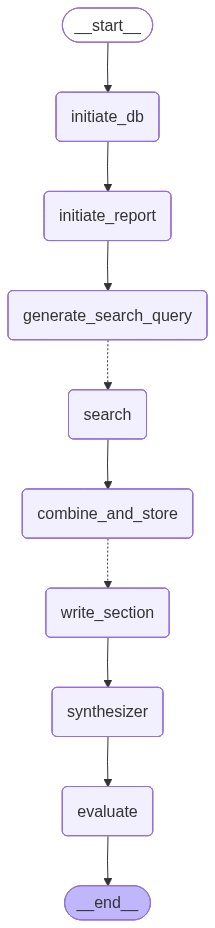

In [38]:
graph

In [39]:
test = {'question':"삼성전자의 LLM 연구는 얼마나 진행중?'"}
thread = {'configurable':default, 'thread_id':'1'}

history = []

for event in graph.stream(test, config= thread):
    try:
        history.append(event)
        for status in event:
            try:
                print(f'# {str(status)[:300]}')
            except:
                continue
            try:
                for key in event[status]:
                    value = str(event[status][key])
                    if len(value)>300:
                        print(f'- {key}: {value[:300]}')
                    else:
                        print(f'- {key}: {value}')
                print('---------')
            except:
                continue
    except:
        continue


# initiate_db
- DART_DB_PATH: ./DART_1cc70
- WEB_DB_PATH: ./WEB_ef806
- current_date: 2025-11-02
---------

# 보고서 작성 개요:
### 서론
삼성전자의 LLM 연구 필요성 및 중요도, 보고서의 목표와 범위 제시

### 삼성전자의 LLM 연구 개발 현황
삼성전자의 LLM 연구 개발 조직, 투자 규모, 주요 연구 분야, 기술 개발 로드맵 분석

### 삼성전자의 LLM 관련 기술 및 제품
삼성전자의 LLM 기반 기술(온디바이스 AI, 생성형 AI 등)과 이를 활용한 제품/서비스(가전, 모바일, 반도체 등) 분석

### 결론 및 전망
삼성전자의 LLM 연구 경쟁력 분석, 향후 LLM 기술 발전 방향 예측, 삼성전자의 LLM 기술 전략 제언

# initiate_report
- plan: sections=[Section(name='서론', description='삼성전자의 LLM 연구 필요성 및 중요도, 보고서의 목표와 범위 제시', content=''), Section(name='삼성전자의 LLM 연구 개발 현황', description='삼성전자의 LLM 연구 개발 조직, 투자 규모, 주요 연구 분야, 기술 개발 로드맵 분석', content=''), Section(name='삼성전자의 LLM 관련 기술 및 제품', description='삼성전자의 LLM 기반 기술(온디바이스 AI, 생성형 AI 등)과 이를 활
---------
# generate_search_query
- queries: ['삼성전자 LLM 연구 개발 필요성', '삼성전자 LLM 기술 중요도', '삼성전자 LLM 보고서 목표 범위', '삼성전자 LLM 연구 조직 구조', '삼성전자 LLM 투자 규모 변화', '삼성전자 LLM 기술 개발 로드맵', '삼성전자 LLM 기반 기술 종류', '삼성전자 LLM 적용 제품 서비스', '삼성전자 온디바이스 AI 기술 동향', '삼성전자 LLM 경쟁사 비교 분석', '

100%|██████████| 15/15 [02:15<00:00,  9.03s/it]


Saved in VDBs
# combine_and_store
- web_docs: [Document(metadata={'type': 'Web', 'source': 'https://www.samsungsds.com/kr/insights/llm-evaluations.html'}, page_content='### LLM 신뢰성 평가를 위한 LLM 활용 동향과 사례 | 인사이트리포트 \n URL: https://www.samsungsds.com/kr/insights/llm-evaluations.html \n * [본문 바로 가기](#container)\n\n[인사이트 리포트](/kr/insights/index.html)
- dart_docs: [Document(metadata={'type': 'DART', 'source': './documents_삼성전자_3/20250311001085_00760.xml'}, page_content='삼성전자주식회사\n재 무 제 표 에 대 한\n\n[표]\n제 56 기\n2024년 01월 01일 | 부터\n2024년 12월 31일 | 까지\n\n[표]\n제 55 기\n2023년 01월 01일 | 부터\n2023년 12월 31일 | 까지\n\n삼 정 회 계 법 인\n\n[표]\n페 이 지-------\n독립된 감사인의 감사보고서     ..
---------
# write_section
- finished_drafts: ['### 서론\n\n삼성전자는 기업 맞춤형 AI 구축을 위해 로컬 LLM에 대한 연구를 진행하고 있으며, 이는 기업의 고유 데이터를 보호하고 특정 전문 분야에 대한 지식의 깊이와 정확성을 높이는 데 중요합니다. 퍼블릭 LLM이 제기하는 도전 과제, 예를 들어 데이터 유출 위험 및 환각 현상 등을 고려할 때, 삼성전자의 LLM 연구는 기업의 경쟁력 강화와 혁신을 위한 필수적인 투자입니다. 본 보고서는 삼성전자의 LLM 연구 현황과 방향성을 제시하고, 그 중요성과 필요성을 강조하는 것을 목표로 합니다. 로컬 LLM 개발을 

In [40]:
result = history[-2]['synthesizer']['result']
print(result)

### 서론

삼성전자는 기업 맞춤형 AI 구축을 위해 로컬 LLM에 대한 연구를 진행하고 있으며, 이는 기업의 고유 데이터를 보호하고 특정 전문 분야에 대한 지식의 깊이와 정확성을 높이는 데 중요합니다. 퍼블릭 LLM이 제기하는 도전 과제, 예를 들어 데이터 유출 위험 및 환각 현상 등을 고려할 때, 삼성전자의 LLM 연구는 기업의 경쟁력 강화와 혁신을 위한 필수적인 투자입니다. 본 보고서는 삼성전자의 LLM 연구 현황과 방향성을 제시하고, 그 중요성과 필요성을 강조하는 것을 목표로 합니다. 로컬 LLM 개발을 고려할 때 주의할 점과 노트북으로 로컬 LLM을 따라잡는 방법도 함께 살펴봅니다.
### 삼성전자의 LLM 연구 개발 현황

삼성전자는 LLM(Large Language Model) 분야에서 활발한 연구 개발을 진행 중입니다. SAIT(Samsung Advanced Institute of Technology)를 중심으로 초소형 추론 모델 'TRM(Tiny Recursion Model)'을 개발하여 거대 모델의 성능을 능가하는 성과를 보이고 있습니다.

TRM은 단 700만 개의 매개변수만으로 일부 논리 추론 과제에서 수천억에서 수조 개의 매개변수를 가진 최신 LLM들을 앞서는 성능을 보여줍니다.  특히, 퍼즐이나 미로와 같은 구조화된 격자 문제 추론에서 뛰어난 성능을 보이며, '스도쿠-익스트림'과 '메이즈-하드'에서 기존 계층적 추론 모델(HRM)의 성능을 크게 상회하는 정확도를 달성했습니다.

삼성전자는 AI 연구의 방향을 '거대화'에서 '깊고 반복적인 사고 방식'으로 전환하는 데 주력하고 있습니다. TRM은 단일 엔비디아 'L40S' GPU만으로도 훈련이 가능하며, 깃허브를 통해 전체 코드를 공개하여 기업과 연구자들이 자유롭게 수정하고 상용화할 수 있도록 지원하고 있습니다.

이러한 연구는 AI 기술 격차가 보안보다 더 큰 리스크라는 인식하에, 폐쇄형 구조에서 벗어나 개방형 혁신을 추구하는 삼성전자의 전략적 방향을 보여줍니다. Dual AI Lay

In [41]:
with open("example.md", "w", encoding="utf-8") as f:
    f.write(result)

In [42]:
result = history[-1]['evaluate']
print(result)

{'quality_score': QualityScore(factual_accuracy=4, relevance=5, completeness=5, coherence_flow=5, clarity_conciseness=4, objectivity=4, overall_score=5)}


만약, Score가 너무 낮다면, Human-in-the-loop를 이용해 피드백을 전달하고, 해당 내용에 맞춰 작업을 수행할 수 있습니다.  